# Exploratory Data Analysis on Donald Trump's Twitter Account

**Clayton Halim**  
_24 June 2017_

This is a exploration of Donald Trump's Twitter account [(@realDonaldTrump)](https://twitter.com/realDonaldTrump).
This data is extracted using the Twitter API.

We start by importing the necessary libraries.

In [1]:
# %matplotlib inline

from datetime import timedelta
from datetime import datetime
import json
import re
import string
import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

We initialize some regex to identify twitter users and urls in a tweet. The porter stemmer is used to stem each word when the tweets are tokenized.

In [4]:
twitter_links = re.compile('https?://t.co/\w+')
twitter_users = re.compile('@[\w]{1,15}')
p_stemmer = PorterStemmer()

Tweets are loaded in but we only want to look at the ones that aren't a reply to another user.

In [5]:
timeline = []
 
with open('users/data/realDonaldTrump.json', 'r') as fp:
    timeline = json.load(fp)

tweets = [tweet for tweet in timeline if tweet['in_reply_to_user_id'] is None]

We then tokenize each tweet and look for the most common unigrams. This gives us a hint on topics he enjoys talking about.

In [6]:
tweet_tokenizer = TweetTokenizer()

tokens = []
texts = [] # list of list of tokens for each tweets (used for LDA)

for tweet in tweets:
    text = twitter_links.sub('', tweet['text']).lower()
    tweet_tokens = [re.sub('[\"|\']', '', token) for token in tweet_tokenizer.tokenize(text) 
                    if token not in string.punctuation and 
                    token not in stopwords.words('english') + ['like', 'thank', '...'] and
                    len(token) > 1]
#     tweet_tokens = [p_stemmer.stem(token) for token in tweet_tokens]
    texts.append(tweet_tokens)
    grams = nltk.ngrams(tweet_tokens, 1)
    tokens.extend(grams)

token_freq = nltk.FreqDist(tokens)
most_freq = token_freq.most_common(75)

for token, freq in most_freq:
    print(token[0], freq)

great 450
hillary 369
clinton 237
people 206
crooked 200
trump 193
america 173
make 156
today 153
join 144
media 137
president 136
get 135
new 125
big 125
jobs 122
country 111
bad 111
@realdonaldtrump 111
#maga 110
going 109
time 106
news 104
many 100
would 99
obama 95
vote 94
never 92
#americafirst 88
back 88
election 85
one 84
american 81
watch 81
fake 78
#makeamericagreatagain 78
tonight 77
much 76
#draintheswamp 75
said 72
want 71
tomorrow 70
last 70
win 69
florida 68
together 67
ohio 65
us 65
support 64
dont 63
#trump2016 63
#imwithyou 62
day 61
even 61
good 61
campaign 61
years 61
@cnn 61
speech 60
democrats 59
obamacare 59
enjoy 59
look 59
job 59
see 58
way 57
bernie 57
state 57
night 57
states 57
russia 56
must 56
@nytimes 55
poll 53
first 52


# Topic Exploration

A naive way to filter out words not relevant to the topics he tweets about is to remove any unigrams that are not nouns. The method works fairly well in this case, where only a couple non-meaningful words pass through (way, want, ...)

In [7]:
freq_nouns = [(word[0][0], word[0][1], word[1]) 
              for word in [(nltk.pos_tag([unigram[0][0]])[0], unigram[1]) 
                            for unigram in most_freq] 
              if word[0][1][0:2] == 'NN']
print(freq_nouns)

[('hillary', 'NN', 369), ('clinton', 'NN', 237), ('people', 'NNS', 206), ('crooked', 'NNS', 200), ('trump', 'NN', 193), ('america', 'NN', 173), ('today', 'NN', 153), ('join', 'NN', 144), ('media', 'NNS', 137), ('president', 'NN', 136), ('jobs', 'NNS', 122), ('country', 'NN', 111), ('@realdonaldtrump', 'NN', 111), ('#maga', 'NN', 110), ('time', 'NN', 106), ('news', 'NN', 104), ('obama', 'NN', 95), ('vote', 'NN', 94), ('election', 'NN', 85), ('watch', 'NN', 81), ('fake', 'NN', 78), ('#makeamericagreatagain', 'NN', 78), ('tonight', 'NN', 77), ('#draintheswamp', 'NN', 75), ('want', 'NN', 71), ('tomorrow', 'NN', 70), ('win', 'NN', 69), ('florida', 'NN', 68), ('ohio', 'NN', 65), ('support', 'NN', 64), ('dont', 'NN', 63), ('#trump2016', 'NN', 63), ('#imwithyou', 'NN', 62), ('day', 'NN', 61), ('campaign', 'NN', 61), ('years', 'NNS', 61), ('@cnn', 'NN', 61), ('speech', 'NN', 60), ('democrats', 'NNS', 59), ('obamacare', 'NN', 59), ('enjoy', 'NN', 59), ('look', 'NN', 59), ('job', 'NN', 59), ('way

We can run sentiment analysis on these tweets and group them together by topics. I think a scatter plot effectively shows the distribution of sentiment and popularity. In the figure below, the red line represents topics that are equally negative as they are positive. As expected, Donald Trump's political opinions are fairly well represented.

In [8]:
def topic_sentiment(topic, tweets):
    """
    Analyzes the sentiments of every tweet that is about a certain topic and returns a dictionary of sentiments
    """
    sar = SentimentIntensityAnalyzer()
    score = {'neg': [], 'pos': [], 'neu': [], 'compound': [], 'popularity': []}

    for tweet in tweets:
        text = tweet['text'].lower()
        words = tweet_tokenizer.tokenize(text)

        if topic in words:
            pol = sar.polarity_scores(text)
            score['pos'].append(pol['pos'])
            score['neu'].append(pol['neu'])
            score['neg'].append(pol['neg'])
            score['compound'].append(pol['compound'])
            score['popularity'].append(tweet['favorite_count'] + tweet['retweet_count'])
    
    return score

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    sents = [(n[0], topic_sentiment(n[0], tweets), n[2]) for n in freq_nouns]
    sents = [(n[0], np.array(n[1]['pos']).mean(), 
                    np.array(n[1]['neg']).mean(), 
                    np.array(n[1]['popularity']).mean(),
                    n[2]) for n in sents]

names = [n[0] for n in sents]
pos = [n[1] for n in sents]
neg = [n[2] for n in sents]
pop = [n[3] for n in sents]
occ = [n[4] for n in sents]  # Occurances of topic

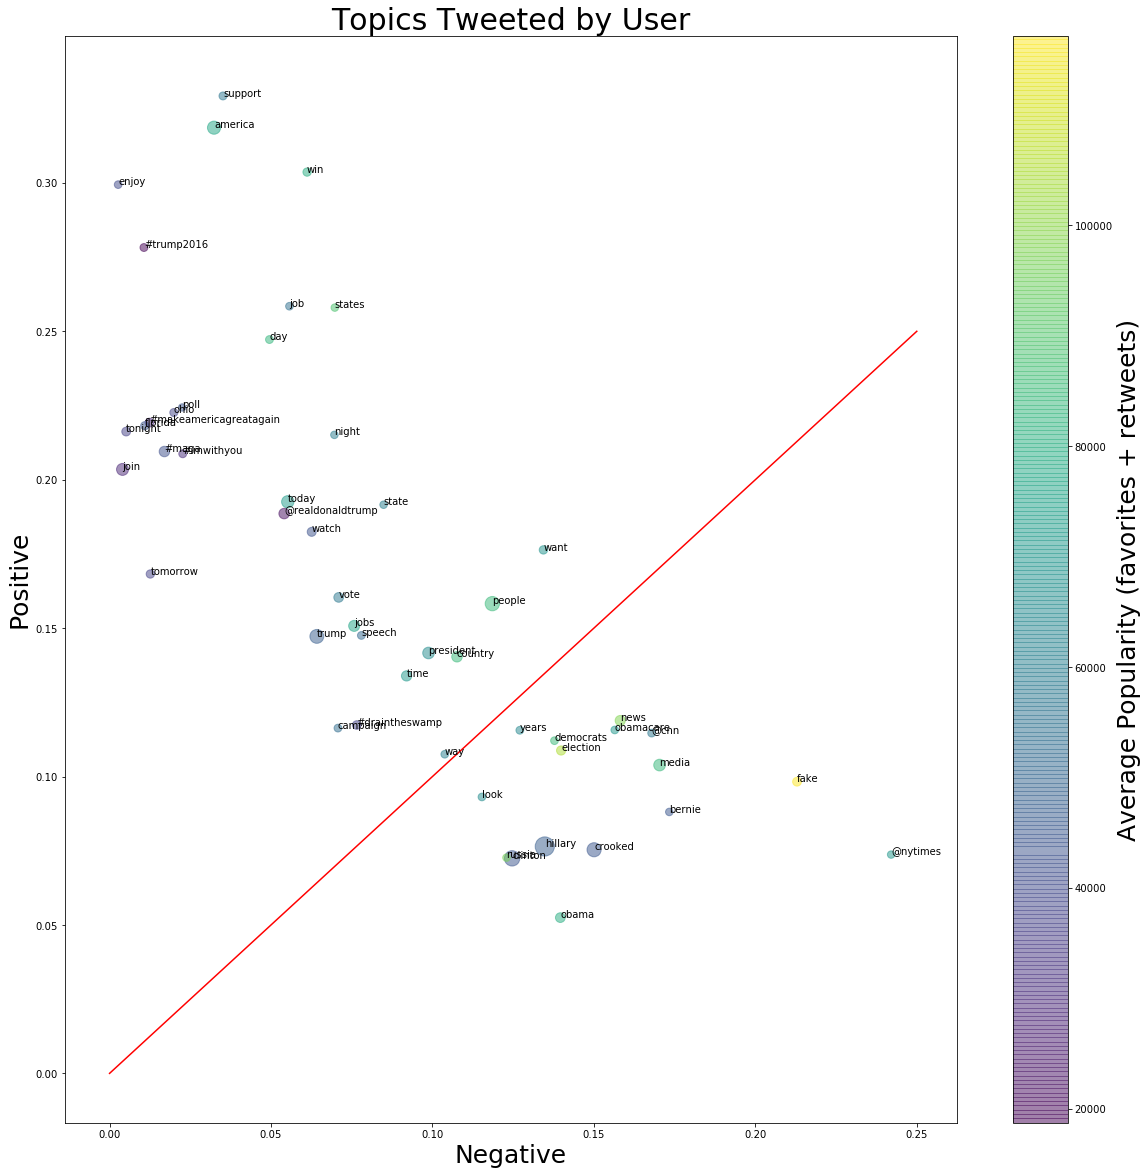

In [10]:
fig, ax = plt.subplots(figsize=(20,20))

s_plot = ax.scatter(x=neg, y=pos, s=(occ * 40), c=pop, alpha=0.5)

for i, txt in enumerate(names):
    ax.annotate(txt, (neg[i], pos[i]))

# plt.xticks(np.arange(0, max(neg), 0.05))
# plt.xlim([0, max(neg) + 0.1])

# plt.yticks(np.arange(min(pos), max(pos), 0.05))
# plt.ylim([0, max(pos) + 0.1])

ax.set_title('Topics Tweeted by User', fontsize=30)
ax.set_xlabel('Negative', fontsize=25)
ax.set_ylabel('Positive', fontsize=25)
ax.plot([0, 0.25], [0, 0.25], 'r-')
s_plot.set_clim([min(pop), max(pop)])
cb = fig.colorbar(s_plot)
cb.set_label('Average Popularity (favorites + retweets)', fontsize=25)
plt.show()


# Hashtags

Hashtags are a great way to see what's trending. Often people use it to promote a certain topic. While it seems like tweets with hashtags are less popular, their popularity is more consistent.

_Note that the blue dots represent the category's average._

# of no hashtags: 2245
# of hashtags: 750


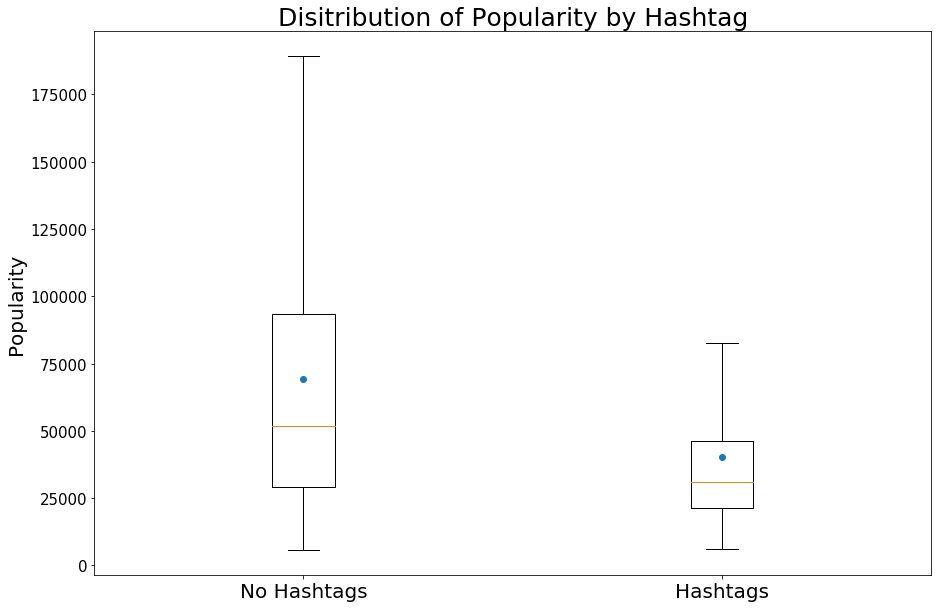

In [13]:
has_hashtags = []
no_hashtags = []

for tweet in tweets:
    if len(tweet['entities']['hashtags']) > 0:
        has_hashtags.append(tweet['favorite_count'] + tweet['retweet_count'])
    else:
        no_hashtags.append(tweet['favorite_count'] + tweet['retweet_count'])

print("# of no hashtags:", len(no_hashtags))
print("# of hashtags:", len(has_hashtags))

plt.figure(figsize=(15, 10))
plt.boxplot([no_hashtags, has_hashtags], showfliers=False)
plt.title('Disitribution of Popularity by Hashtag', fontsize=25)
plt.ylabel('Popularity', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks([1, 2], ['No Hashtags', 'Hashtags'], fontsize=20)
means = [np.mean(x) for x in [no_hashtags, has_hashtags]]
plt.scatter([1, 2], means)
plt.show()

We can use sentiment analysis again to see how much engagement tweets get based on whether a tweet is positive, neutral, or negative. It seems that tweets with that are stronger opinionated (positive/negative) seem to be more popular.

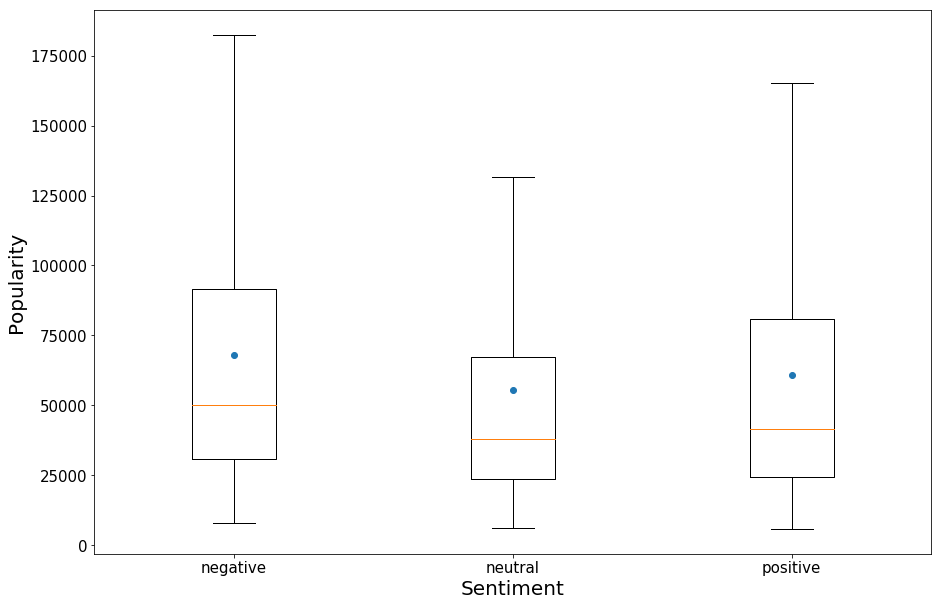

In [39]:
sar = SentimentIntensityAnalyzer()

pos = []
neu = []
neg = []

for tweet in tweets:
    popularity = tweet['favorite_count'] + tweet['retweet_count']
    sent = sar.polarity_scores(tweet['text'])['compound']
    
    if sent >= 0.1:
        pos.append(popularity)
    elif sent <= -0.1:
        neg.append(popularity)
    else:
        neu.append(popularity)

plt.figure(figsize=(15, 10))
# plt.title('Popularity Distribution of Tweets by Sentiment', fontsize=25)
plt.ylabel('Popularity', fontsize=20)
plt.xlabel('Sentiment', fontsize=20)
plt.scatter([1, 2, 3], [np.mean(neg), np.mean(neu), np.mean(pos)])
plt.boxplot([neg, neu, pos], showfliers=False)
plt.yticks(fontsize=15)
plt.xticks([1, 2, 3], ['negative', 'neutral', 'positive'], fontsize=15)
plt.show()

# Popularity Over Time

As Trump gains more followers over time, how does the engagement in his tweets reflect that?

In [41]:
def calc_popularity(tweet):
    return tweet['favorite_count'] + tweet['retweet_count']

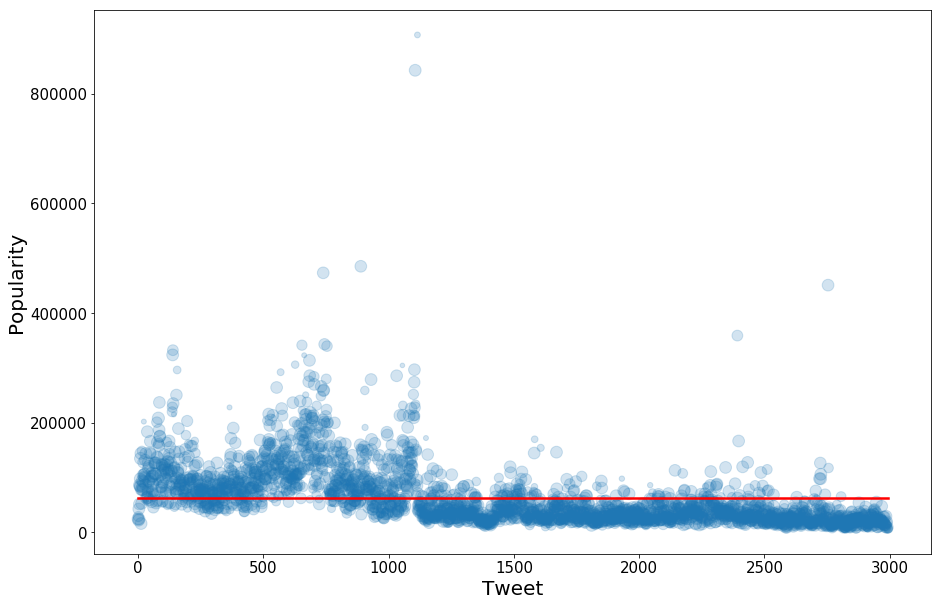

In [42]:
popularities = [calc_popularity(tweet) for tweet in tweets]
lens = [len(tweet['text']) for tweet in tweets]
plt.figure(figsize=(15, 10))
# plt.title('Popularity of Most Recent Tweet', fontsize=25)
plt.ylabel('Popularity', fontsize=20)
plt.xlabel('Tweet', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, len(popularities)], np.ones(2) * np.mean(popularities), linewidth=2.5, c='r')
plt.scatter(range(len(popularities)), popularities, s=lens, alpha=0.2)
plt.show()

Interestingly, his earlier tweets were more popular than average (inidicated by the red line). The most popular tweet seems to be on the boundary from when his tweets were more popular than average, to then regularily below average.

In [15]:
max([(tweet['text'], tweet['favorite_count'] + tweet['retweet_count'], 
      tweet['created_at']) for tweet in tweets], key=lambda x: x[1])

('TODAY WE MAKE AMERICA GREAT AGAIN!',
 907569,
 'Tue Nov 08 11:43:14 +0000 2016')

Trump's most popular tweet is about his victory in the 2016 American election. It seems that after he became president, people started engaging his tweets less than during the election. 

# Frequency of Tweets by Hour

What time does Trump enjoy tweeting at? Assuming he is tweeting in the eastern coast of the United States (where his HQ and Washington DC is located), we subtract 4 hours off UTC time to calculate when his tweets are posted. Unsurprisingly, he seems to tweet most often early in the morning and late at night, probably when he isn't at work.

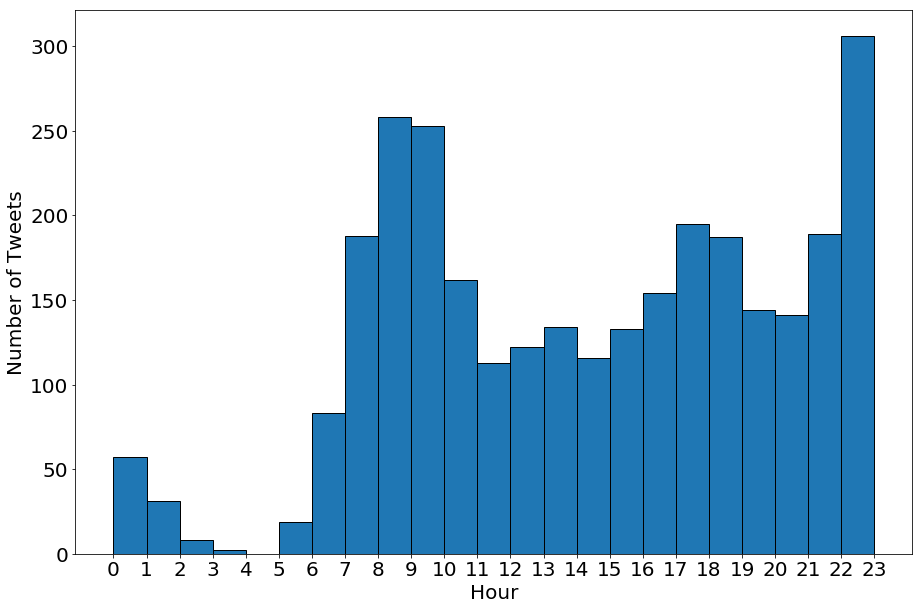

In [45]:
hr_of_day = []

est = timedelta(hours=4)
for tweet in tweets:
    dt = datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y') - est
    hr_of_day.append(dt.hour)

plt.figure(figsize=(15, 10))
plt.hist(hr_of_day, ls='solid', edgecolor='black', bins=range(24))
plt.xticks(np.arange(0, 24, 1), fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Frequency of Tweets by Hour', fontsize=25)
plt.ylabel('Number of Tweets', fontsize=20)
plt.xlabel('Hour', fontsize=20)
plt.show()

# Tweet Clustering

To take topic modelling a little further, we cluster Trumps tweets into different groups using a more sophisticated method called tf-idf (explained later on).

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
def tokenize_stem(text):
    tweet_tokenizer = TweetTokenizer()
    stemmer = PorterStemmer()
    tokens = [token for token in tweet_tokenizer.tokenize(text)]
    filtered = [stemmer.stem(token) for token in tokens if re.search('[a-zA-Z]', token)]
    return filtered

def tokenize(text):
    tweet_tokenizer = TweetTokenizer()
    tokens = [token.lower() for token in tweet_tokenizer.tokenize(text)]
    filtered = [token for token in tokens if re.search('[a-zA-Z]', token)]
    return filtered

Tokenize words from each tweet but remove any duplicates. We want to preserve order so we use a list, but use a set to keep track if a word has been seen as we're parsing through the tweets.

In [18]:
seen = set()
words_tokenized = []
words_stemmed = []

for tweet in tweets:
    txt = tweet['text']
    tokens = tokenize(txt)
    for token in tokens:
        if token not in seen:
            words_tokenized.append(token)
            seen.add(token)

words_stemmed = [p_stemmer.stem(word) for word in words_tokenized]

We put every word into a dataframe indexed by their stemmed word. This makes it easy to see the whole family of a given word.

In [19]:
vocab_frame = pd.DataFrame({'word': words_tokenized}, index=(words_stemmed))

In [20]:
vocab_frame.loc['thank']

,word
thank,thank
thank,thanking
thank,thanks
thank,thankful


We use the Scikit-Learn to transform all the tweets into a **term frequency - inverse document frequency** (tf-idf) matrix. Each row represents a tweet and each column represents a word, essentially each entry in the matrix is a weighted frequency of a word in a tweet.

In [21]:
tfidf = TfidfVectorizer(max_df=0.8, stop_words=stopwords.words('english'), 
                        tokenizer=tokenize_stem, vocabulary=set(words_tokenized),
                        min_df=0.2, use_idf=True, ngram_range=(1,3))

tfidf_matrix = tfidf.fit_transform([tweet['text'] for tweet in tweets])

In [22]:
print(tfidf_matrix.shape)

(2995, 7357)


In [23]:
terms = [p_stemmer.stem(term) for term in tfidf.get_feature_names()]

We can use a cosine similarity measure to compare how similar to document vectors are in the tf-idf matrix. Where 1 is identical and 0 is unrelated at all (ie. vectos are perpendicular), thus ```1 - cosine_similarity(tfidf_matrix)``` results in the distance between to documents.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [27]:
dist.shape

(2995, 2995)

We also then cluster tweets together by using k-means on the tf-idf matrix. The number of clusters at the moment is arbitrarily chosen but can be changed as needed.

In [28]:
from sklearn.cluster import KMeans

In [30]:
num_clusters = 4

km = KMeans(n_clusters=num_clusters, random_state=42)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 2.14 s, sys: 4 ms, total: 2.15 s
Wall time: 2.15 s


In [31]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

In [32]:
topics = [list() for i in range(num_clusters)]
for i in range(len(tweets)):
    topics[clusters[i]].append(tweets[i]['text'])

The tweets are put into a data frame so we can do some do some analysis on them.

In [33]:
tweet_df = pd.DataFrame({'tweet': tweets, 
                            'text': [tweet['text'] for tweet in tweets],
                            'popularity': [tweet['favorite_count'] + tweet['retweet_count'] for tweet in tweets],
                            'cluster': clusters})
tweet_df.head()

,cluster,popularity,text,tweet
0,2,24145,"From my first day in office, we’ve taken swift...",{'created_at': 'Wed Jun 28 22:32:47 +0000 2017...
1,2,28664,Democrats purposely misstated Medicaid under n...,{'created_at': 'Wed Jun 28 21:26:27 +0000 2017...
2,2,21811,"Today, I hosted an immigration roundtable ahea...",{'created_at': 'Wed Jun 28 21:15:37 +0000 2017...
3,2,42371,It was my great honor to welcome the 2016 Worl...,{'created_at': 'Wed Jun 28 21:06:39 +0000 2017...
4,2,23904,"#ICYMI- on Monday, I had the great honor of we...",{'created_at': 'Wed Jun 28 20:19:38 +0000 2017...


All tweets are grouped by their cluster, we can see that _cluster 2_ contains the most amount of teets, where _cluster 3_ has the least out of all.

In [34]:
tweet_df['cluster'].value_counts()

2    2308
1     358
0     214
3     115
Name: cluster, dtype: int64

We can look at the words nearest each centroid to understand what our topics are made up of. This is done by looking up the stem of each word, if a stem indexes multiple word (ex. thank: thanking, thankful, thanks), then it takes the first word that occurs in the vocab data frame (just for consistency). This is taken into account in 7-11 in the code below.

In [35]:
topic_labels = []
for i in range(num_clusters):
    print('Cluster {} words: '.format(i + 1), end='')
    
    topic_words = []
    for ind in order_centroids[i, :6]:
        words = vocab_frame.loc[terms[ind]].values
        if len(words) > 1:
            word = words[0][0]
        else:
            word = words[0]
        topic_words.append(word)
    topic_labels.append(', '.join(topic_words))
    print(topic_labels[i])

Cluster 1 words: join, enjoy, interviewed, tonight, tickets, tomorrow
Cluster 2 words: thank, #makeamericagreatagain, #americafirst, great, #maga, #trump2016
Cluster 3 words: clinton, great, crooked, trump, job, media
Cluster 4 words: america, make, great, safe, thank, going


We can do some inferencing and see that the _cluster 1_ represents all his self promotional events such as TV interviews, _cluster 2_ represents his election campaign tweets, _cluster 3_ represents the entities he dislikes such as democrats and the media (but also seems to cluster some of his presidential work as well), _cluster 4_ represents his presidential work. 

In [36]:
for topic in range(len(topics)):
    print('Cluster {}: {}'.format(topic + 1, ' |*|*| '.join(topics[topic][0:3]))) # Padding between each tweet
    print() # Spacing between each cluster

Cluster 1: Will be on @foxandfriends. Enjoy! |*|*| My daughter, Ivanka, will be on @foxandfriends tomorrow morning. Enjoy! |*|*| Join me live at the @WhiteHouse.

➡️https://t.co/9VOb99W42r https://t.co/sjb5VHLHYH

Cluster 2: Great night in Iowa - special people. Thank you! |*|*| Thank you @FoxNews "Huge win for President Trump and GOP in Georgia Congressional Special Election." |*|*| Thoughts and prayers with the sailors of USS Fitzgerald and their families. Thank you to our Japanese allies for th… https://t.co/BBvmTFxVkk

Cluster 3: From my first day in office, we’ve taken swift action to lift the crushing restrictions on American energy. Remarks… https://t.co/VBoEubD59k |*|*| Democrats purposely misstated Medicaid under new Senate bill - actually goes up. https://t.co/necCt4K6UH |*|*| Today, I hosted an immigration roundtable ahead of two votes taking place in Congress tomorrow. Watch and read more… https://t.co/5k8WzW1t68

Cluster 4: Very grateful for the 9-O decision from the U. S.

We can even use our existing tf-idf model to predict the categories of new tweets! However any tweets based on new categories will be forcefully put into one of the existing ones as the model has not learned about any of r

In [38]:
new_tweets = ['.@WashTimes stats "Democrats have willingly used Moscow disinformation to influence the presidential election again Donald Trump."',
              'Remember, when you hear the words "sources say" from the Fake Media, often times those sources are made up and do not exist',
             'My son, Donald, will be interviewed by @seanhannity tonight at 10:00 P.M. He is a great person who loves our country!',
             'Big wins against ISIS!',
             'Working hard to get the Olympics for the United States (L.A.). Stay tuned!',
             'The Senate Democrats have only confirmed 48 of 197 Presidential Nominees. They can\'t win so all they do is slow things down & obstruct!',
             'If Chelsea Clinton were asked to hold a seat for her mother, as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!',
             'James Comey leaked CLASSIFIED INFORMATION to the social media. That is so illegal!',
             'MAKE AMERICA GREAT AGAIN']

In [39]:
new_idf = tfidf.transform(new_tweets)

In [40]:
km.predict(new_idf)

array([2, 2, 0, 2, 2, 2, 2, 2, 3], dtype=int32)

We then aggregate the tweets again to see the spread of popularity in each cluster. In the case of trumps tweets, clusters 1 and 2 seem to have the least amount of variance. They also seem to be less popular on average. An example of insight we could make is that Trump's tweets that are reminders for his interviews don't receive that much engagement.

In [41]:
pops = [group.popularity.values for name, group in tweet_df.groupby('cluster')]

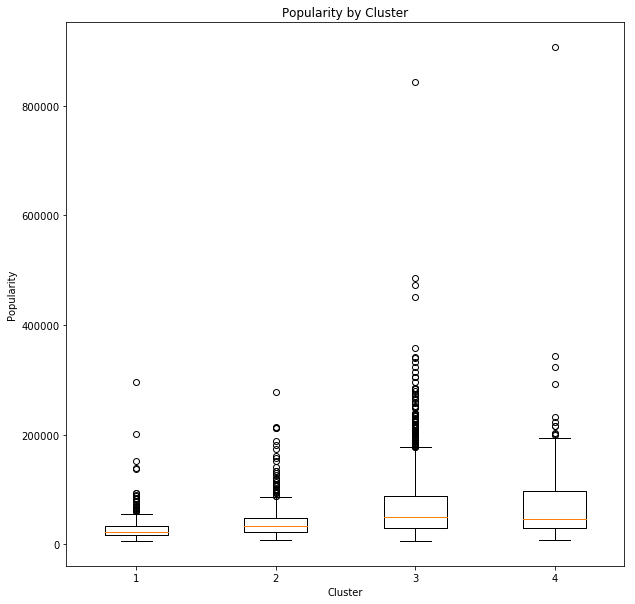

In [42]:
plt.figure(figsize=(10, 10))
plt.boxplot(pops)
plt.title('Popularity by Cluster')
plt.ylabel('Popularity')
plt.xlabel('Cluster')
plt.show()

We can use a dimensionality reduction algorithm to visualize the clusters in a 2D graph. We use **principal component analysis (PCA)** to project the data.

In [43]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2)

pos = pca.fit_transform(dist)

PCA retains about 67% of the orignal variance of the dataset, not ideal like 95% but the visualization suffices.

In [45]:
print('{}, sum = {}'.format(pca.explained_variance_, sum(pca.explained_variance_)))

[ 0.45398645  0.21186325], sum = 0.6658497058405641


In [46]:
xs = pos[:, 0]
ys = pos[:, 1]
colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [47]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

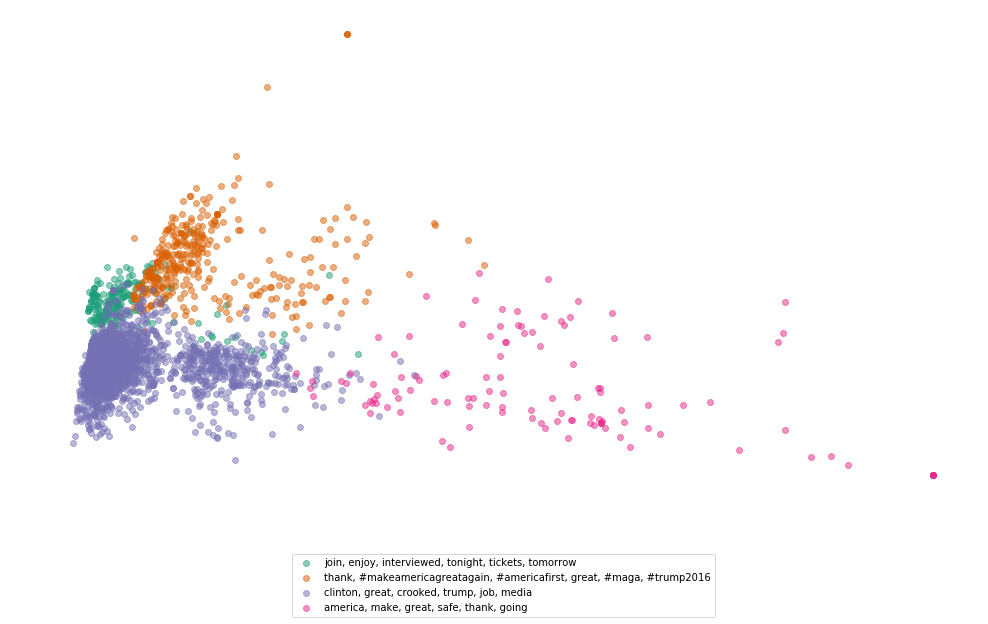

In [48]:
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)
for name, group in groups:
    ax.scatter(group.x, group.y, marker='o', color=colors[name], label=topic_labels[name], alpha=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
plt.axis('off')
plt.show()